# Proyecto - Entrega final

Alumno: Javier López Malone

Profesor: David Silvera

Tutor: Karen Tamarin

# Contenido

[Abstracto](#abastracto)

# Abastracto

< Escribir abstract >

# Información del dataset

< dataset >

# Definición de objetivos

Identificar entidades 

# Lectura de datos

## Importación de librerías

In [159]:
# standar libraries
import re
import os
import importlib
from collections import Counter

# third-party libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

# local libraries
import utils.review_utils as utils

importlib.reload(utils)

<module 'utils.review_utils' from 'c:\\Apps\\Cursos\\data-science-3-challenge\\Challenge\\notebooks\\utils\\review_utils.py'>

## Carga del dataset

In [160]:
ds_full_path = os.path.join("..", "dataset", "airfrance_tripadvisor_reviews.csv")
df_original = pd.read_csv(ds_full_path)

df_original.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,I travel a lot - and I travel often. Last week...,2024-11-13
1,1,Terrible experience with Airfrance,"This review is regarding flight AF185, we book...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,I recently flew with Air France on flight #185...,2024-11-12
3,1,Horrible,Wow!!! What a horrible experience!! I've alway...,2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,I spent a fantastic 10-day vacation in Hong Ko...,2024-11-11


### Descripción del dataset

In [161]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         2560 non-null   int64 
 1   title          2560 non-null   object
 2   text           2560 non-null   object
 3   publishedDate  2560 non-null   object
dtypes: int64(1), object(3)
memory usage: 80.1+ KB


## Limpieza y preparación de datos

Seleccionamos solo las columnas _rating_, _title_ y _text_ para trabajar, eliminamos la columna _publishedDate_. A su vez, unificamos title y text en un solo campo.

In [162]:
df = df_original[['rating','title', 'text']].copy()
df['text'] = df.apply(lambda x: ': '.join([x['title'], x['text']]), axis=1)
df.drop(['title'], axis=1, inplace=True)

df.head(2)

,rating,text
0,1,WORST AIRLINE: I travel a lot - and I travel o...
1,1,Terrible experience with Airfrance: This revie...


Agrego una columna categorica con valores _positivo_, _neutro_ o _negativo_, basado en el rating.

In [163]:
df['sentiment'] = df['rating'].apply(lambda x: 
    'positive' if x >= 4 else 'negative')
utils.print_list(df.head(2),['rating','text', 'sentiment'])

rating:                                                                                             1
text:
WORST AIRLINE: I travel a lot - and I travel often. Last week I flew from Texas USA to Paris to
Algiers - and then back the same way for the return flight. First before my trip I purchased luggage
checked luggage and then after 2 weeks I saw that it wasn't showing on my ticket. So I call customer
service and they said yeah we don't see it here. I told them okay. I have the confirmation from
PayPal and also I have confirmation on my bank statement that they took out the full payment for the
luggage and still they wouldn't fix the issue. Finally 3 days before my flight I had to call again
and they finally put it on my ticket that I had paid for it. Then at the airport they give me many
additional security screenings and at the Paris airport they weigh your carry-on bags that includes
the backpack I had and my small carry-on luggage which has to be under 12 kg. Mine was 14 so I
eith

### Limpieza del texto

Limpio el texto de caracteres que no sean espacio o palabras y lo cambio a minúsculas.

In [164]:
df['text_cleaned'] = df['text'].apply(lambda text: re.sub(r'[^\w\s]', '', text, flags=re.IGNORECASE).lower())
utils.print_list(df.tail())

rating:                                                                                             3
text:
Air France nothing exceptional: Flight with Air France nothing exceptional. Onboard entertainment
okay, staff not the friendliest. Only advantage ability to book seats with extra legroom.
sentiment:                                                                                   negative
text_cleaned:
air france nothing exceptional flight with air france nothing exceptional onboard entertainment okay
staff not the friendliest only advantage ability to book seats with extra legroom
----------------------------------------------------------------------------------------------------

rating:                                                                                             2
text:
unpleasant surprise: Expensive ticket, a plane from Paris to Madrid was old and dirty, the staff is
indifferent. Flight takes a little more than 2 hours but get only 2 small muffins and glass of


### Preparación de datos

Creo una columna tokenizada

In [165]:
df['tokenized_text'] = df['text_cleaned'].apply(word_tokenize)
utils.print_list(df.tail(2))

rating:                                                                                             5
text:
AIR FRANCE HAS SPOILED ME!: Besides the astonishing new First Class cabin, Air France has by far the
BEST cuisine onboard! That's the very French gastronomy heritage, #1 on this planet. Special remark:
When flying First, you must take some time at La Premiere lounge/Charles De Gaulle Airport in Paris
- a lifetime experience!
sentiment:                                                                                   positive
text_cleaned:
air france has spoiled me besides the astonishing new first class cabin air france has by far the
best cuisine onboard thats the very french gastronomy heritage 1 on this planet special remark when
flying first you must take some time at la premiere loungecharles de gaulle airport in paris  a
lifetime experience
tokenized_text:
['air', 'france', 'has', 'spoiled', 'me', 'besides', 'the', 'astonishing', 'new', 'first', 'class',
'cabin', 'air', 'fr

Elimino stopwords de la columna tokenizada

In [166]:
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

df['tokenized_text'] = df['tokenized_text'].apply(lambda x: utils.remove_stop_words(x, english_stopwords))
utils.print_list(df.tail(2))

rating:                                                                                             5
text:
AIR FRANCE HAS SPOILED ME!: Besides the astonishing new First Class cabin, Air France has by far the
BEST cuisine onboard! That's the very French gastronomy heritage, #1 on this planet. Special remark:
When flying First, you must take some time at La Premiere lounge/Charles De Gaulle Airport in Paris
- a lifetime experience!
sentiment:                                                                                   positive
text_cleaned:
air france has spoiled me besides the astonishing new first class cabin air france has by far the
best cuisine onboard thats the very french gastronomy heritage 1 on this planet special remark when
flying first you must take some time at la premiere loungecharles de gaulle airport in paris  a
lifetime experience
tokenized_text:
['air', 'france', 'spoiled', 'besides', 'astonishing', 'new', 'first', 'class', 'cabin', 'air',
'france', 'far', 'best'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Creo una columna y aplico lematización.

In [167]:
lemmatizer = WordNetLemmatizer()

df['lemmatized_text'] = df['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
utils.print_list(df.tail(2))

rating:                                                                                             5
text:
AIR FRANCE HAS SPOILED ME!: Besides the astonishing new First Class cabin, Air France has by far the
BEST cuisine onboard! That's the very French gastronomy heritage, #1 on this planet. Special remark:
When flying First, you must take some time at La Premiere lounge/Charles De Gaulle Airport in Paris
- a lifetime experience!
sentiment:                                                                                   positive
text_cleaned:
air france has spoiled me besides the astonishing new first class cabin air france has by far the
best cuisine onboard thats the very french gastronomy heritage 1 on this planet special remark when
flying first you must take some time at la premiere loungecharles de gaulle airport in paris  a
lifetime experience
tokenized_text:
['air', 'france', 'spoiled', 'besides', 'astonishing', 'new', 'first', 'class', 'cabin', 'air',
'france', 'far', 'best'

#### Análisis del texto

In [168]:
df['tagged_text'] = df['lemmatized_text'].apply(lambda x: utils.pos_tagging(pos_tag(x)))
utils.print_list(df.tail(2))

rating:                                                                                             5
text:
AIR FRANCE HAS SPOILED ME!: Besides the astonishing new First Class cabin, Air France has by far the
BEST cuisine onboard! That's the very French gastronomy heritage, #1 on this planet. Special remark:
When flying First, you must take some time at La Premiere lounge/Charles De Gaulle Airport in Paris
- a lifetime experience!
sentiment:                                                                                   positive
text_cleaned:
air france has spoiled me besides the astonishing new first class cabin air france has by far the
best cuisine onboard thats the very french gastronomy heritage 1 on this planet special remark when
flying first you must take some time at la premiere loungecharles de gaulle airport in paris  a
lifetime experience
tokenized_text:
['air', 'france', 'spoiled', 'besides', 'astonishing', 'new', 'first', 'class', 'cabin', 'air',
'france', 'far', 'best'

# Análisis exploratorio

In [169]:
df['text_cleaned'] = df['tagged_text'].apply(lambda x: ' '.join(x))
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

El siguiente gráfico muestra la distribución de la longitud de reseñas.

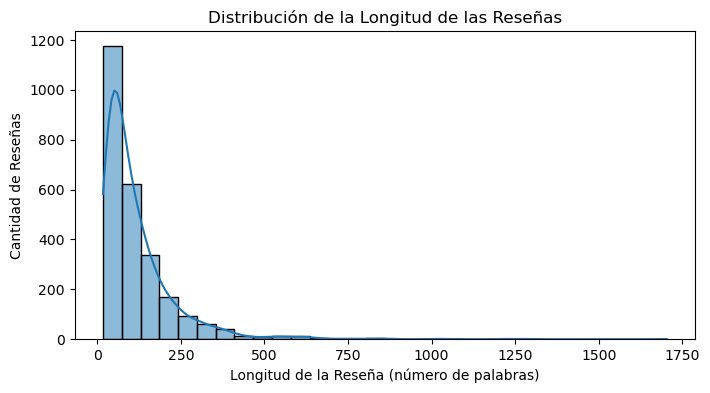

In [170]:

# Mostrar distribución de la longitud de las reseñas
plt.figure(figsize=(8, 4))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud de la Reseña (número de palabras)')
plt.ylabel('Cantidad de Reseñas')
plt.show()

Distribución de las 30 palabras mas frecuentes en todas las reseñas.

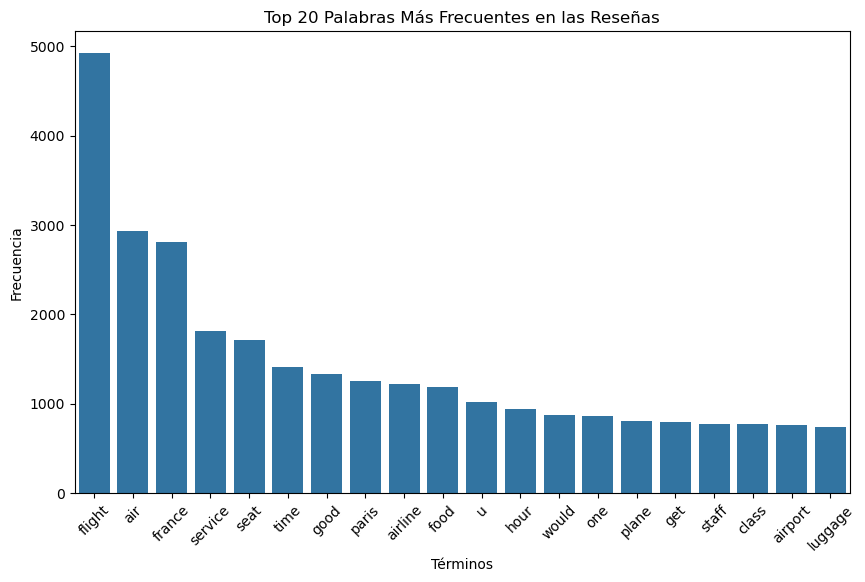

In [171]:
utils.plot_frequent_terms(
    data=df, 
    column='tagged_text', 
    term_count=20, 
    title='Top 20 Palabras Más Frecuentes en las Reseñas'
)

Frecuencia por pares de palabras, sin considerar la marca (air france), en todas las reseñas.

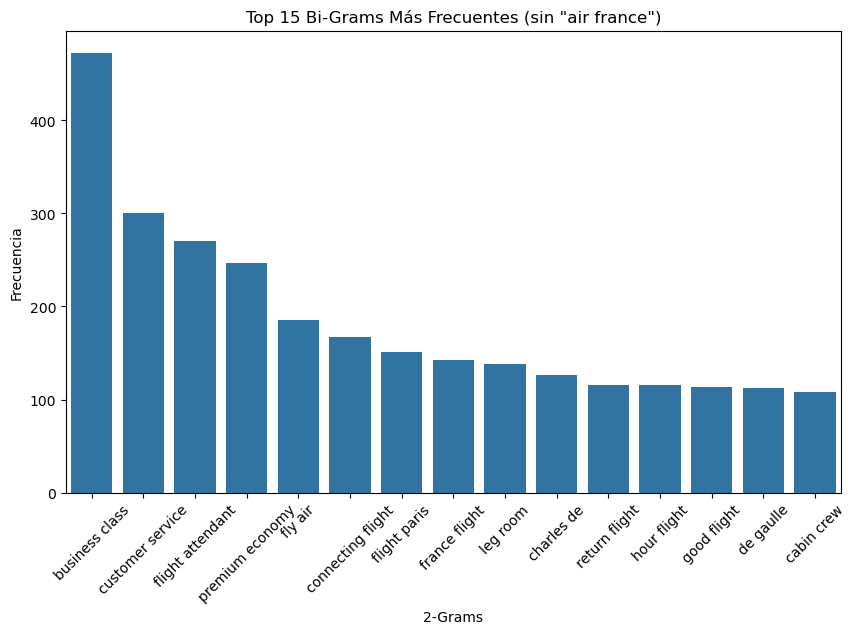

In [172]:
utils.plot_frequent_terms(
    data=df, 
    column='tagged_text', 
    term_count=15, 
    title='Top 15 Bi-Grams Más Frecuentes (sin "air france")', 
    filter_terms=('air', 'france'), 
    ngram_size=2
)

Distribución de las 10 palabras mas frecuentes en reseñas positivas.

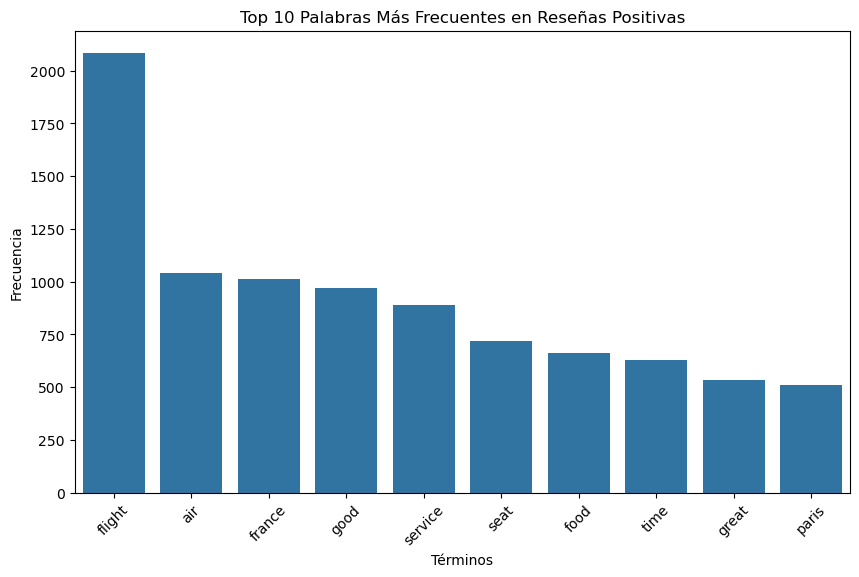

In [173]:
positive_reviews = df[df['sentiment'] == 'positive']
utils.plot_frequent_terms(
    data=positive_reviews, 
    column='tagged_text', 
    term_count=10, 
    title='Top 10 Palabras Más Frecuentes en Reseñas Positivas'
)

Frecuencia por pares de palabras, sin considerar la marca (air france), en reseñas positivas.

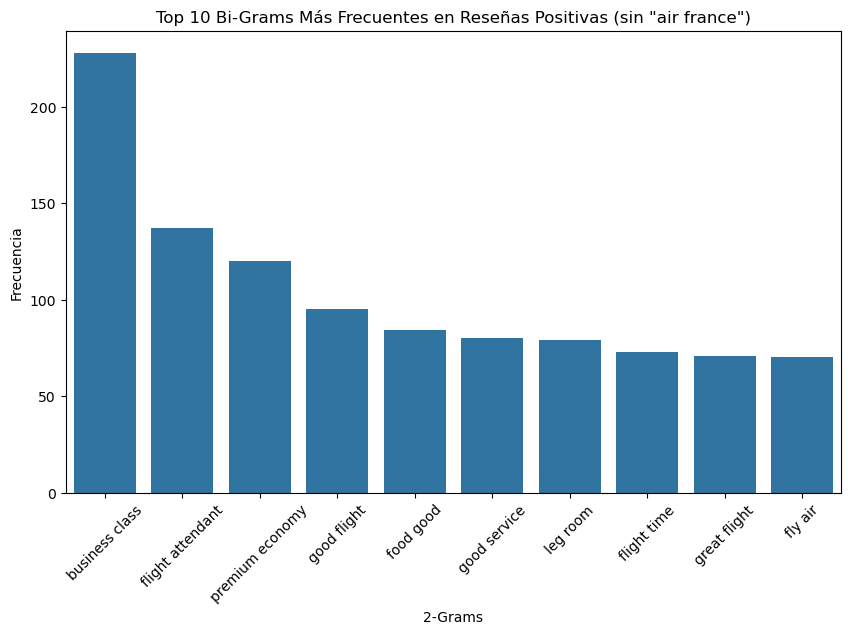

In [174]:
utils.plot_frequent_terms(
    data=positive_reviews, 
    column='tagged_text', 
    term_count=10, 
    title='Top 10 Bi-Grams Más Frecuentes en Reseñas Positivas (sin "air france")', 
    filter_terms=('air', 'france'), 
    ngram_size=2
)

Distribución de las 10 palabras mas frecuentes en reseñas negativas.

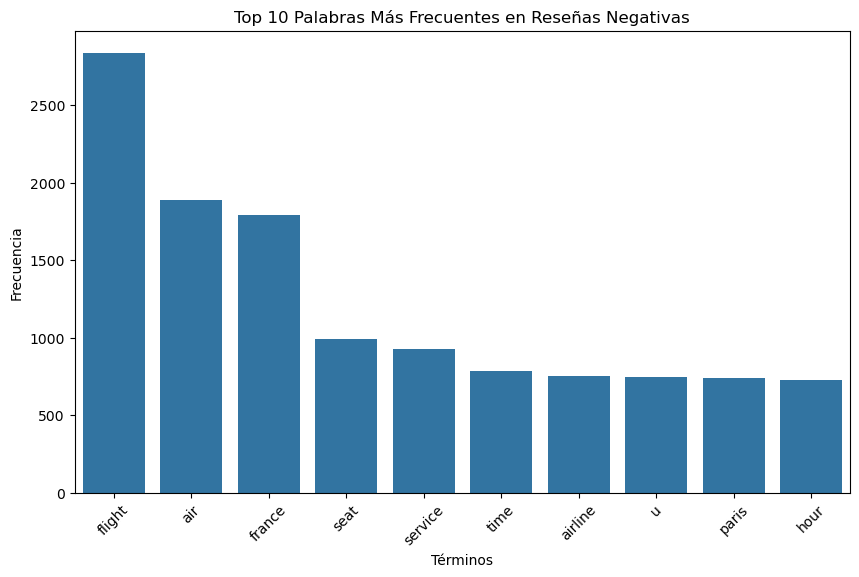

In [175]:
negative_reviews = df[df['sentiment'] == 'negative']
utils.plot_frequent_terms(
    data=negative_reviews, 
    column='tagged_text', 
    term_count=10, 
    title='Top 10 Palabras Más Frecuentes en Reseñas Negativas'
)

Frecuencia por pares de palabras, sin considerar la marca (air france), en reseñas negativas.

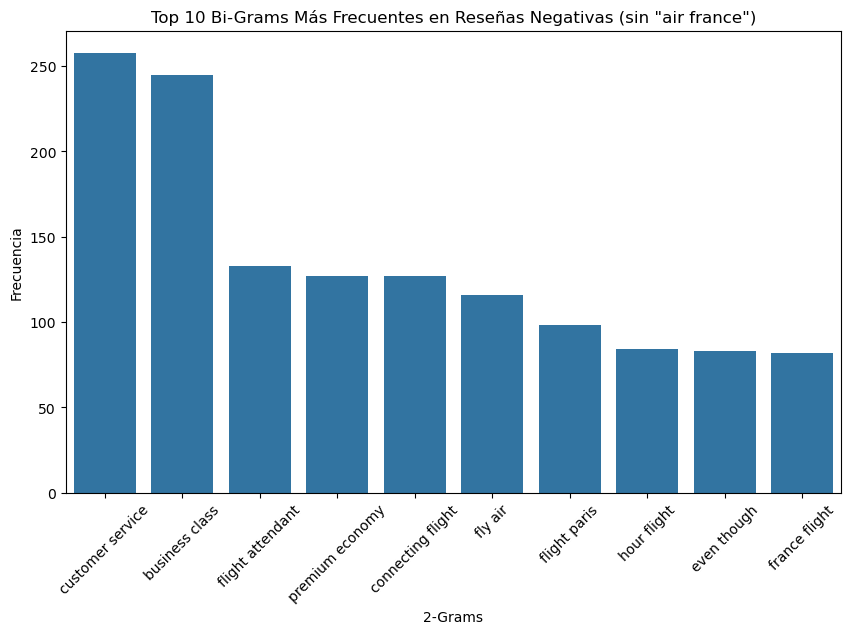

In [176]:
utils.plot_frequent_terms(
    data=negative_reviews, 
    column='tagged_text', 
    term_count=10, 
    title='Top 10 Bi-Grams Más Frecuentes en Reseñas Negativas (sin "air france")', 
    filter_terms=('air', 'france'), 
    ngram_size=2
)

A continuación se muestra la nube de palabras para todas las reseñas, reseñas positivas y reseñas negativas.

In [177]:
positive_reviews['text_cleaned'].head()

10    pleasantly supervised air france hop flight ex...
12    one best airline world pro 1 food quality food...
16    air france finacial masacists air france best ...
23    pro con advice visit cdg iad af pro good profe...
24    great great great great flight clean plane nic...
Name: text_cleaned, dtype: object

In [178]:
all_reviews = ' '.join(df['text_cleaned'])
all_positive_reviews = ' '.join(positive_reviews['text_cleaned'])
all_negative_reviews = ' '.join(negative_reviews['text_cleaned'])


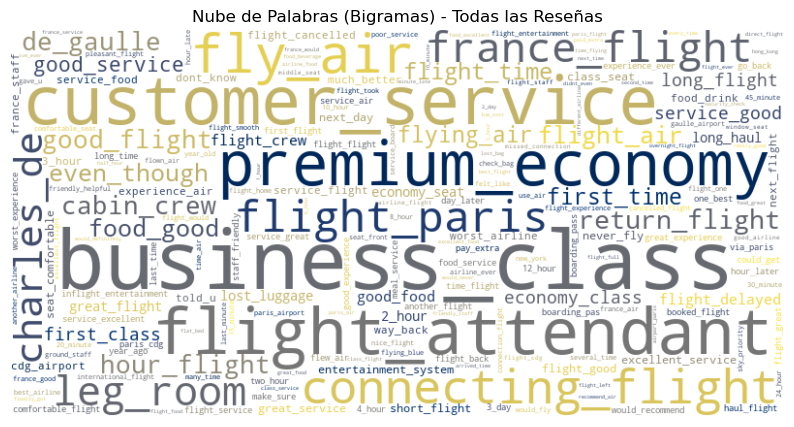

In [179]:
utils.plot_wordcloud_bigrams(all_reviews, title='Nube de Palabras (Bigramas) - Todas las Reseñas', filter_terms=('air', 'france'))

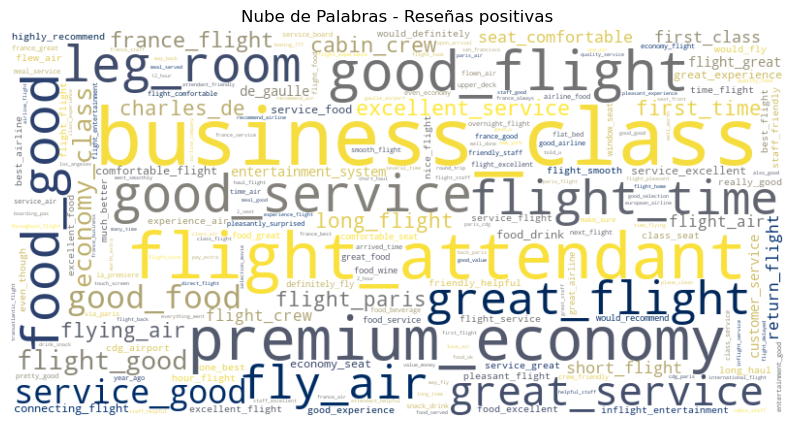

In [180]:
utils.plot_wordcloud_bigrams(all_positive_reviews, title='Nube de Palabras - Reseñas positivas', filter_terms=('air', 'france'))

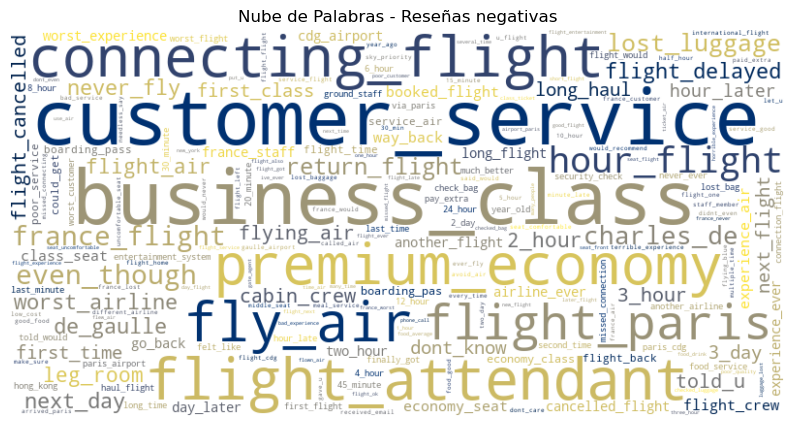

In [181]:
utils.plot_wordcloud_bigrams(all_negative_reviews, title='Nube de Palabras - Reseñas negativas', filter_terms=('air', 'france'))

Se entrena un modelo de BOW y se evalúa el mismo.

In [ ]:
X = df['text_cleaned']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = make_pipeline(
    CountVectorizer(ngram_range=(1, 4)),
    LogisticRegression(max_iter=800)
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.869140625
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.88      0.87       260
    positive       0.87      0.86      0.87       252

    accuracy                           0.87       512
   macro avg       0.87      0.87      0.87       512
weighted avg       0.87      0.87      0.87       512



Se crean frases de prueba y se evalúa la predicción.

In [ ]:

test_phrases = [
    "Air France offers exceptional service and comfort.", 
    "The flight was delayed and there was no compensation.", 
    "The cabin crew was professional and courteous.", 
    "I had a smooth and pleasant flight with Air France.", 
    "Air France’s website is difficult to navigate.", 
    "The flight attendants were not friendly or welcoming.", 
    "I loved the spacious seating and legroom.", 
    "Air France lost my luggage and never updated me.", 
    "I highly recommend Air France for long-haul flights.", 
    "My seat was broken and I couldn’t recline it.", 
    "Great food and entertainment options onboard.", 
    "The customer service was unhelpful and rude.", 
    "I had a wonderful experience flying with Air France.", 
    "The check-in process was confusing and time-consuming.", 
    "I felt safe and secure during my flight with Air France.", 
    "The overall service was below my expectations.", 
    "The flight was on time and very efficient.", 
    "Air France’s meals are always tasty and satisfying.", 
    "I didn’t receive any assistance with my special request.", 
    "The staff is always friendly and helpful.", 
    "The flight was extremely noisy and uncomfortable.", 
    "Air France canceled my flight without offering an alternative.", 
    "The staff was attentive and responsive to my needs.", 
    "I was disappointed with the food quality onboard.", 
    "The flight crew was efficient and professional.", 
    "I always feel well taken care of with Air France.", 
    "Air France overbooked my flight and didn’t provide a solution.", 
    "I had a long layover without enough amenities.", 
    "The flight attendants made me feel very comfortable.", 
    "I had to wait a long time for my baggage to arrive.", 
    "Air France makes international travel a breeze.", 
    "The flight was delayed by hours.", 
    "I was not satisfied with the inflight entertainment options.", 
    "Air France’s customer service is top-notch.", 
    "Air France didn’t honor my seat preference.", 
    "Great experience, I would fly with Air France again.", 
    "I was frustrated with Air France’s poor communication.", 
    "The seats were uncomfortable and cramped.", 
    "The staff didn’t offer any assistance when I asked.", 
    "Air France’s lounges are always well-equipped and relaxing.", 
    "My experience with Air France was frustrating and stressful.", 
    "I always feel well taken care of with Air France.", 
    "I had a terrible experience with Air France’s customer support.", 
    "Air France’s flight crew seemed disinterested and inattentive.", 
    "The check-in process was efficient and hassle-free.", 
    "Air France is great for both short and long flights.", 
    "Air France overcharged me for extra baggage.", 
    "I would definitely fly with Air France again.", 
    "Air France didn’t provide any refreshments on the flight."
]
for phrase in test_phrases:
    prediction = pipeline.predict([phrase])
    print(f"Phrase: {phrase}")
    print(f"Prediction: {prediction[0]}")
    print('-' * 50)

Phrase: Air France offers exceptional service and comfort.
Prediction: positive
--------------------------------------------------
Phrase: The flight was delayed and there was no compensation.
Prediction: negative
--------------------------------------------------
Phrase: The cabin crew was professional and courteous.
Prediction: positive
--------------------------------------------------
Phrase: I had a smooth and pleasant flight with Air France.
Prediction: positive
--------------------------------------------------
Phrase: Air France’s website is difficult to navigate.
Prediction: negative
--------------------------------------------------
Phrase: The flight attendants were not friendly or welcoming.
Prediction: positive
--------------------------------------------------
Phrase: I loved the spacious seating and legroom.
Prediction: positive
--------------------------------------------------
Phrase: Air France lost my luggage and never updated me.
Prediction: negative
---------------

In [ ]:
print("Conteo de sentimientos en el conjunto completo:")
print(df['sentiment'].value_counts())

# Contar las reseñas positivas y negativas en el conjunto de entrenamiento
print("\nConteo de sentimientos en el conjunto de entrenamiento:")
print(y_train.value_counts())

# Contar las reseñas positivas y negativas en el conjunto de prueba
print("\nConteo de sentimientos en el conjunto de prueba:")
print(y_test.value_counts())

Conteo de sentimientos en el conjunto completo:
sentiment
negative    1329
positive    1231
Name: count, dtype: int64

Conteo de sentimientos en el conjunto de entrenamiento:
sentiment
negative    1069
positive     979
Name: count, dtype: int64

Conteo de sentimientos en el conjunto de prueba:
sentiment
negative    260
positive    252
Name: count, dtype: int64


## Modelo TF-IDF

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear un pipeline de TF-IDF con Logistic Regression
pipeline_tf = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 4)),  # Convertir texto en una matriz TF-IDF
    LogisticRegression(max_iter=1000)     # Clasificador Logistic Regression
)

# Entrenar el modelo
pipeline_tf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_tf = pipeline_tf.predict(X_test)

# Evaluar el modelo
print(f'Accuracy: {accuracy_score(y_test, y_pred_tf)}')
print('Classification Report:')
print(classification_report(y_test, y_pred_tf))

Accuracy: 0.8359375
Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.88      0.85       260
    positive       0.87      0.79      0.83       252

    accuracy                           0.84       512
   macro avg       0.84      0.84      0.84       512
weighted avg       0.84      0.84      0.84       512



In [186]:
# Probar el modelo con diferentes frases y mostrar las predicciones
for phrase in test_phrases:
    prediction = pipeline_tf.predict([phrase])
    print(f"Phrase: {phrase}")
    print(f"Prediction: {prediction[0]}")
    print('-' * 50)

Phrase: Air France offers exceptional service and comfort.
Prediction: positive
--------------------------------------------------
Phrase: The flight was delayed and there was no compensation.
Prediction: negative
--------------------------------------------------
Phrase: The cabin crew was professional and courteous.
Prediction: positive
--------------------------------------------------
Phrase: I had a smooth and pleasant flight with Air France.
Prediction: positive
--------------------------------------------------
Phrase: Air France’s website is difficult to navigate.
Prediction: negative
--------------------------------------------------
Phrase: The flight attendants were not friendly or welcoming.
Prediction: positive
--------------------------------------------------
Phrase: I loved the spacious seating and legroom.
Prediction: positive
--------------------------------------------------
Phrase: Air France lost my luggage and never updated me.
Prediction: negative
---------------